# Time Series Analysis

*References:*<br>
[1] https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/<br>
[1] https://www.machinelearningplus.com/time-series/time-series-analysis-python/<br>
[1] https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/<br>
[2] https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/<br>
[3] https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/<br>
[4] https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/<br>
http://people.duke.edu/~rnau/411arim3.htm<br>
https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
BoxCox Transformation:<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html<br>

<br>

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html


https://www.kaggle.com/poiupoiu/how-to-use-sarimax

---

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Andre\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\Andre\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


---

## Import data

In [2]:
filename = 'data/airline-passengers.csv'
df = pd.read_csv(filename)

In [3]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


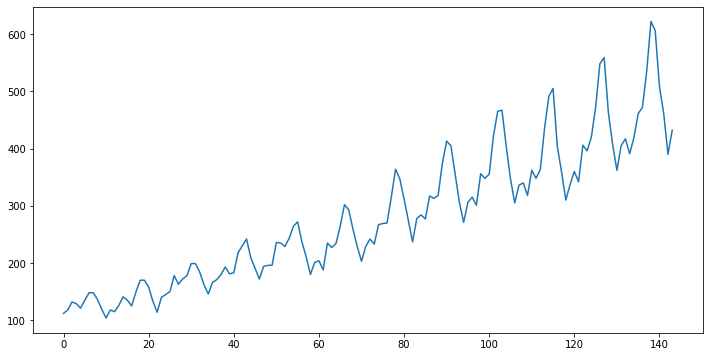

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'])

---

## Preprocessing

### Creating days, month metrics

In [7]:
df['day'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['weekday'] = df['day'].dt.dayofweek
df['month'] = df['day'].dt.month
df['year'] = df['day'].dt.year
df.set_index('day', inplace=True)

In [8]:
df.head()

,Month,Passengers,weekday,month,year
day,,,,,
1949-01-01,1949-01,112,5,1,1949
1949-02-01,1949-02,118,1,2,1949
1949-03-01,1949-03,132,1,3,1949
1949-04-01,1949-04,129,4,4,1949
1949-05-01,1949-05,121,6,5,1949


### Separating training set and evaluation set

In [9]:
# flag_eval = df['evaluation_set']
df_train = df
# df_eval = df[flag_eval]

### Checking consumption distribution

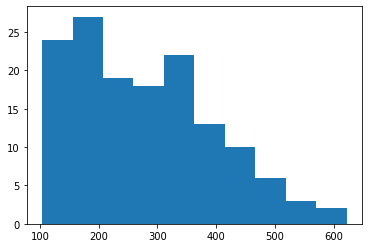

In [10]:
plt.hist(df_train['Passengers'], bins=10)
plt.show()

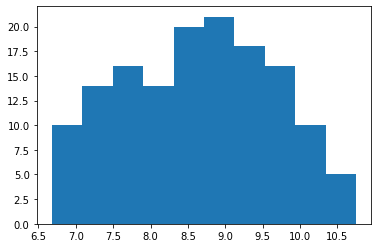

In [11]:
df_train['Passengers'], lambda_opt = boxcox(df_train['Passengers'])
plt.hist(df_train['Passengers'], bins=10)
plt.show()

In [12]:
lambda_opt

0.14802256545004658

---

## Data Exploratory

### Time Series plot

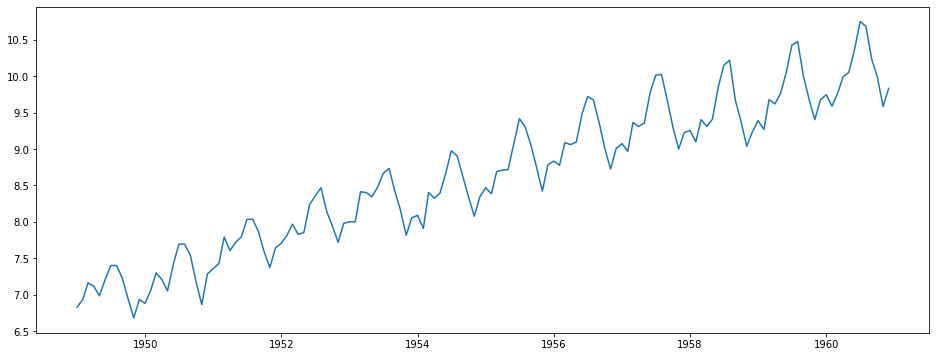

In [13]:
plt.figure(figsize=(16,6))
plt.plot(df_train['Passengers'])
plt.show()

### Monthly YoY

In [14]:
month_agg = df.groupby(by=['year', 'month']).median()
month_agg.reset_index(inplace=True)

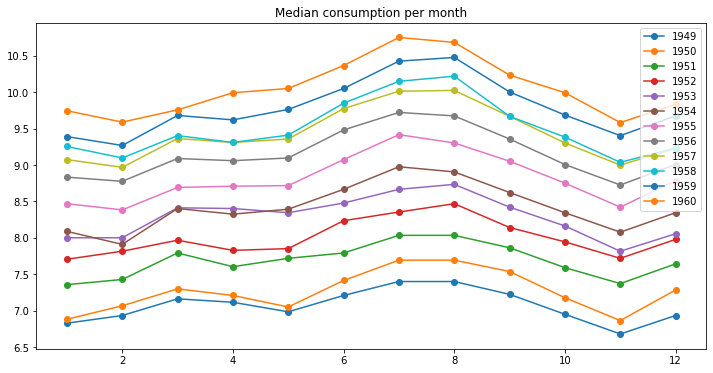

In [15]:
plt.figure(figsize=(12,6))
for year in month_agg['year'].unique():
    flag = month_agg['year'] == year
    filtered = month_agg[flag]
    plt.plot(filtered['month'], filtered['Passengers'], '-o', label=year)
plt.title('Median consumption per month')
plt.legend()
plt.show()

### Monthly Seasonality

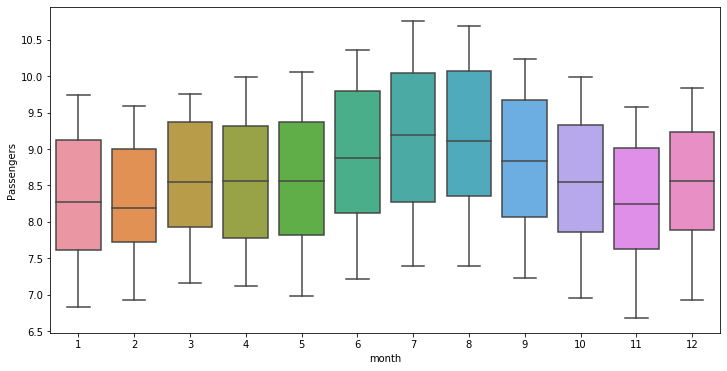

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='Passengers', data=df)
plt.show()

### Weekly Seasonality

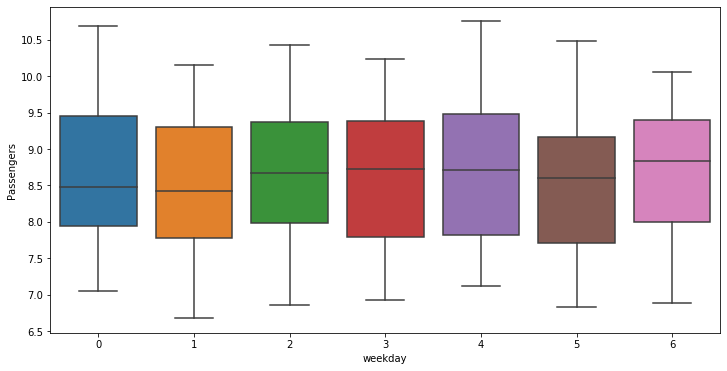

In [17]:
plt.figure(figsize=(12,6))
sns.boxplot(x='weekday', y='Passengers', data=df)
plt.show()

---

## Auxiliary Functions

In [18]:
def mape(df, actual, model):
    diff = df[actual] - df[model]
    return np.mean(abs(diff/df[actual]))

In [19]:
def plot_model(train, test, model):
    plt.figure(figsize=(12, 6))
    plt.plot(train['Passengers'], label='train')
    plt.plot(test['Passengers'], label='test: actual')
    plt.plot(test[model], label='test: '+model)
    cmape = mape(test, 'Passengers', model)
    title = 'Model: ' + model + ' (MAPE: ' + str(round(cmape, 4)) + ')'
    plt.title(title, fontsize=15)
    plt.legend()
    plt.show()

---

## Models

**Train/Test Split in Training Set**: 75% train, 25% test

In [20]:
split = .80
n_train = int(df_train.shape[0]*split)
train = df_train[['Passengers']][:n_train]
test = df_train[['Passengers']][n_train:]

### Benchmark: Naive - average over 365-day period

In [21]:
model = 'bench'

In [22]:
ma12 = train['Passengers'].rolling(window=12).mean()
test[model] = ma12.iloc[-1]

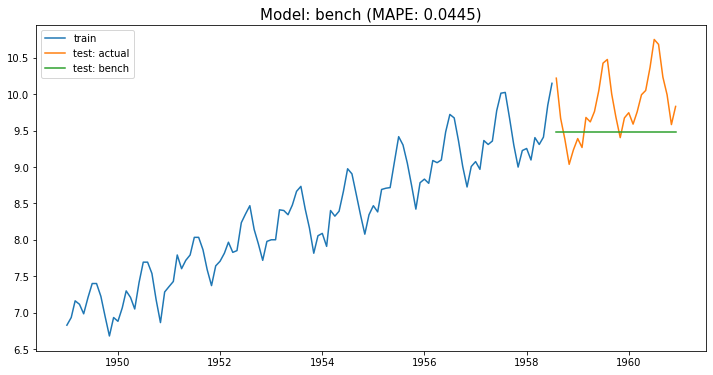

In [23]:
plot_model(train, test, model)

### Trend + Seasonal Decomposition

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

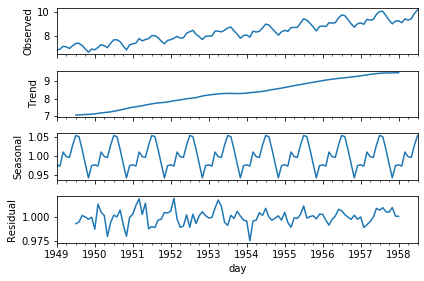

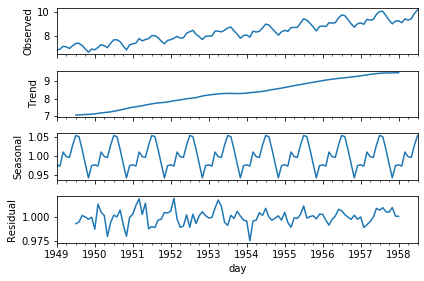

In [25]:
result_mult = seasonal_decompose(train['Passengers'], model='multiplicative')
result_mult.plot()

### Stationarity

In [26]:
adf, pvalue, *_ = adfuller(train['Passengers'].values, autolag='AIC')
print('>>> ADF: original consumption')
print('    stats:  {:.4f}'.format(adf))
print('    pvalue: {:.4f}'.format(pvalue))

>>> ADF: original consumption
    stats:  -1.3240
    pvalue: 0.6181


In [27]:
train['diff_consumption'] = train.diff(1)['Passengers']

In [28]:
adf, pvalue, *_ = adfuller(train['diff_consumption'][1:].values, autolag='AIC')
print('>>> ADF: original consumption')
print('    stats:  {:.4f}'.format(adf))
print('    pvalue: {:.4f}'.format(pvalue))

>>> ADF: original consumption
    stats:  -2.9072
    pvalue: 0.0445


### AR

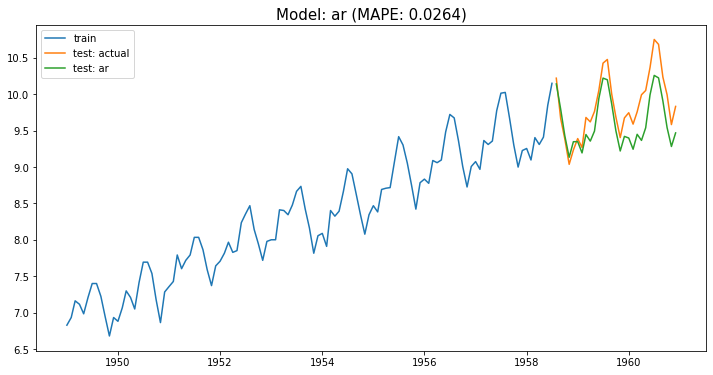

In [29]:
model = SARIMAX(train['Passengers'], order=(12,1,0), enforce_invertibility=False, enforce_stationarity=False)
result = model.fit()
test['ar'] = result.predict(start=test.index.min(), end=test.index.max())
plot_model(train, test, 'ar')

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  115
Model:              SARIMAX(12, 1, 0)   Log Likelihood                  95.123
Date:                Mon, 13 Apr 2020   AIC                           -164.247
Time:                        23:11:39   BIC                           -130.122
Sample:                    01-01-1949   HQIC                          -150.428
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0043      0.063      0.068      0.946      -0.118       0.127
ar.L2         -0.0673      0.069     -0.972      0.331      -0.203       0.068
ar.L3         -0.0080      0.056     -0.144      0.886      -0.117       0.101
ar.L4         -0.0974      0.070     -1.389      0.165      -0.235       0.040
ar.L5          0.0092      0.060      0.154      0.878      -0.108       0.126
ar.L6         -0.0675      0.064     -1.053      0.292      -0.193       0.058
ar.L7         -0.0309      0.077     -0.401      0.689      -0.182       0.120
ar.L8         -0.1249      0.065     -1.914      0.056      -0.253       0.003
ar.L9         -0.0057      0.064     -0.089      0.929      -0.131       0.119
ar.L10        -0.0870      0.064     -1.353      0.176      -0.213       0.039
ar.L11         0.0424      0.060      0.711      0.477      -0.075       0.159
ar.L12         0.8428      0.061     13.828      0.000       0.723       0.962
sigma2         0.0091      0.001      7.872      0.000       0.007       0.011
===================================================================================
Ljung-Box (Q):                       75.01   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.00   Prob(JB):                         0.15
Heteroskedasticity (H):               0.17   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### MA

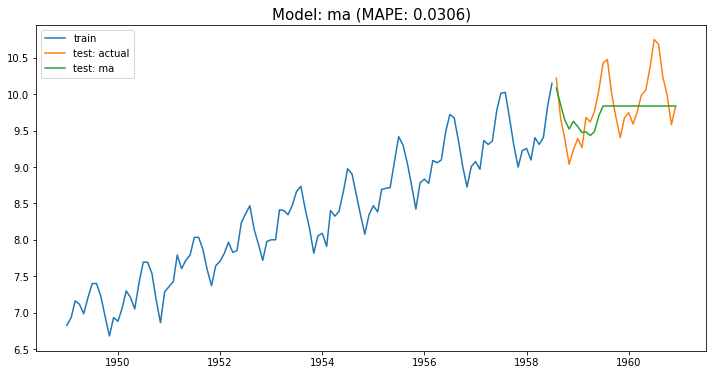

In [31]:
model = SARIMAX(train['Passengers'], order=(0,1,12), enforce_invertibility=False, enforce_stationarity=False)
result = model.fit()
test['ma'] = result.predict(start=test.index.min(), end=test.index.max())
plot_model(train, test, 'ma')

### SARIMA: X-12

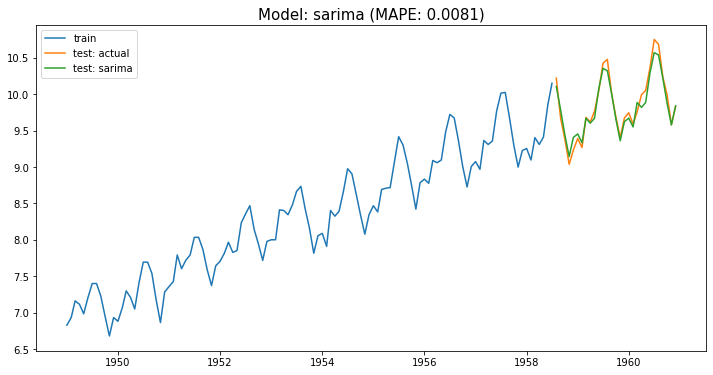

In [32]:
model = SARIMAX(train['Passengers'], order=(0,1,1), seasonal_order=(0,1,1,12), enforce_stationarity=False)
result = model.fit()
test['sarima'] = result.predict(start=test.index.min(), end=test.index.max())
plot_model(train, test, 'sarima')

In [33]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  94.107
Date:                            Mon, 13 Apr 2020   AIC                           -182.214
Time:                                    23:11:55   BIC                           -174.782
Sample:                                01-01-1949   HQIC                          -179.220
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3179      0.095     -3.345      0.001      -0.504      -0.132
ma.S.L12      -0.5092      0.106     -4.796      0.000      -0.717      -0.301
sigma2         0.0068      0.001      7.182      0.000       0.005       0.009
===================================================================================
Ljung-Box (Q):                       38.02   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.56   Prob(JB):                         0.39
Heteroskedasticity (H):               0.30   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Auto ARIMA

In [34]:
smodel = pm.auto_arima(train['Passengers'],
                       test='adf',
                       start_p=0, max_p=3,
                       start_q=0, max_q=3,
                       start_d=0, max_d=1,
                       seasonal=True, m=12,
                       start_D=0, max_D=1,
                       start_P=0, max_P=3,
                       start_Q=0, max_Q=3,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-175.831, BIC=-170.581, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-203.160, BIC=-192.660, Fit time=1.117 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-207.511, BIC=-197.011, Fit time=0.722 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-205.852, BIC=-192.728, Fit time=1.048 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-184.747, BIC=-176.872, Fit time=0.177 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-205.755, BIC=-192.630, Fit time=0.908 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-201.308, BIC=-193.433, Fit time=0.459 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 

In [35]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 107.756
Date:                            Mon, 13 Apr 2020   AIC                           -207.511
Time:                                    23:12:07   BIC                           -197.011
Sample:                                         0   HQIC                          -203.259
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.003     -0.032      0.974      -0.007       0.007
ma.L1         -0.2964      0.090     -3.288      0.001      -0.473      -0.120
ma.S.L12      -0.5174      0.105     -4.912      0.000      -0.724      -0.311
sigma2         0.0068      0.001      7.311      0.000       0.005       0.009
===================================================================================
Ljung-Box (Q):                       34.15   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.73   Prob(JB):                         0.66
Heteroskedasticity (H):               0.33   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
test['auto_arima'], ci = smodel.predict(n_periods=test.shape[0], return_conf_int=True)

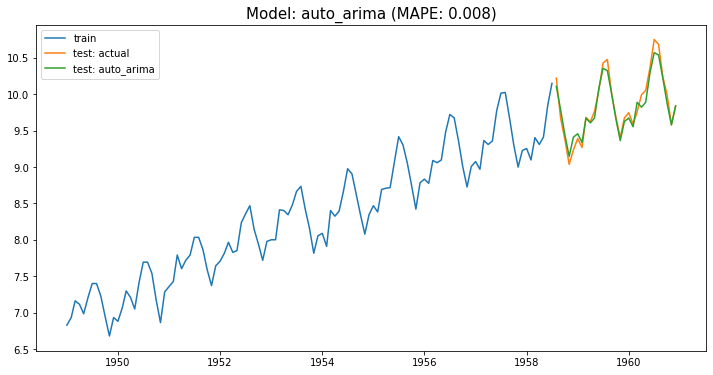

In [44]:
plot_model(train, test, 'auto_arima')

(array([5., 2., 2., 5., 6., 2., 3., 0., 3., 1.]),
 array([-0.18008557, -0.14473021, -0.10937484, -0.07401948, -0.03866412,
        -0.00330876,  0.0320466 ,  0.06740196,  0.10275733,  0.13811269,
         0.17346805]),
 <a list of 10 Patch objects>)

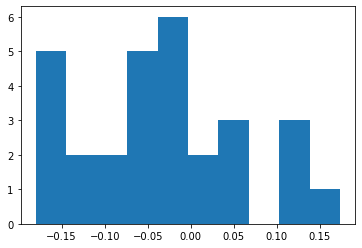

In [38]:
diff = test['sarima'] - test['Passengers']
plt.hist(diff, bins=10)

## Final Model Forecast

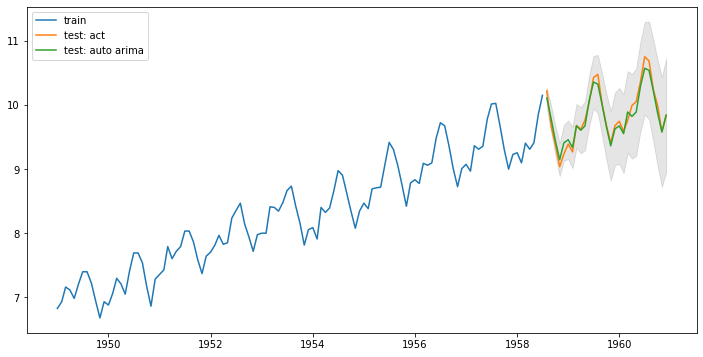

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(train['Passengers'], label='train')
plt.plot(test['Passengers'], label='test: act')
plt.plot(test['auto_arima'], label='test: auto arima')
plt.fill_between(test.index, ci[:,1], ci[:,0], color='k', alpha=.1)
plt.legend()
plt.show()